In [37]:
using Images
using TestImages
using MLDataUtils
import LearnBase: nobs, getobs, gettargets
using UnicodePlots: barplot

# Defining our custom data container

In [38]:
imgexts = (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp")
isimage(path) = splitext(path)[2] in imgexts

struct ImageFolderDataset
    basedir
    classes
    images
    labels
    transform
    loader

    function ImageFolderDataset(basedir; transform = nothing, loader = Images.load)
        classes = findclasses(basedir)
        images, labels = walkdata(basedir, classes)
        new(basedir, classes, images, labels, transform, loader)
    end
end

function findclasses(basedir)
    classes = [dir for dir in readdir(basedir) if isdir(joinpath(basedir, dir))]
    sort!(classes)
end

function walkdata(basedir, classes::Vector{String})
    imagepaths, labels = String[], String[]
    for class in classes
        classdir = joinpath(basedir, class)
        isdir(classdir) || continue

        for (root, _, fnames) in walkdir(classdir)
            for fname in fnames
                path = joinpath(root, fname)
                if isimage(path)
                    push!(imagepaths, path)
                    push!(labels, class)
                end
            end
        end
    end
    imagepaths, labels
end

walkdata (generic function with 1 method)

Lets use `MLDataUtils.nobs()` to define the size of our dataset

In [39]:
nobs(ds::ImageFolderDataset) = length(ds.labels)
Base.show(io::IO, ds::ImageFolderDataset) = print(io, "$(typeof(ds))($(nobs(ds)) observations)")

Our dataset expects a data folder of this design:
```
.
├── Class1
│   ├── Img1.jpg
│   ├── Img2.jpg
│   └── ...
├── Class2
│   ├── Img1.jpg
│   └── ...
```
Lets load our dataset from a directory containing images of 4 dogs and 5 cats

In [68]:
path = "path/to/data"
ds = ImageFolderDataset(path)

ImageFolderDataset(9 observations)

In [43]:
function getobs(ds::ImageFolderDataset, idx::Int)    
    image = ds.loader(ds.images[idx])
    isnothing(ds.transform) || return ds.transform(image)
    image
end

getobs (generic function with 46 methods)

In [44]:
function getobs(ds::ImageFolderDataset, idx::AbstractArray)
    length(idx) > 0 || return []
    cat([getobs(ds, i) for i in idx]..., dims=4)
end

getobs (generic function with 46 methods)

In [45]:
function centercrop(x::AbstractArray{T}, h::Int, w::Int) where {T}
    croptop = round(Int, (height(x) - h) / 2)
    cropleft = round(Int, (width(x) - w) / 2)

    padtop = max(-croptop, 0)
    padleft = max(-cropleft, 0)
    padhslice = padtop+1:min(padtop + height(x), h)
    padwslice = padleft+1:min(padleft + width(x), w)

    croptop = max(croptop, 0)
    cropleft = max(cropleft, 0)
    crophslice = croptop+1:min(croptop + h, height(x))
    cropwslice = cropleft+1:min(cropleft + w, width(x))

    padimg = zeros(T, h, w)
    padimg[padhslice, padwslice] = x[crophslice, cropwslice]
    return padimg
end

function getnewsize(x::AbstractArray, sz::Int)
    factor = sz / min(height(x), width(x))
    return round(Int, height(x) * factor), round(Int, width(x) * factor)
end

function resize(x::AbstractArray, h, w)
    if ismissing(w)
        h, w = getnewsize(x, h)
    elseif ismissing(h)
        h, w = getnewsize(x, w)
    end
    imresize(x, h, w)
end


μimagenet = [0.485, 0.456, 0.406]
σimagenet = [0.229, 0.224, 0.225]

normalize(x::AbstractArray, μ, σ) = (x .- μ) ./ σ

normalize (generic function with 1 method)

In [46]:
function tfms(x)
    x = resize(x, 38, missing)
    x = centercrop(x, 32, 32)
    x = channelview(RGB.(x))
    x = normalize(x, μimagenet, σimagenet)
    permutedims(x, (3, 2, 1))
end

tfms (generic function with 1 method)

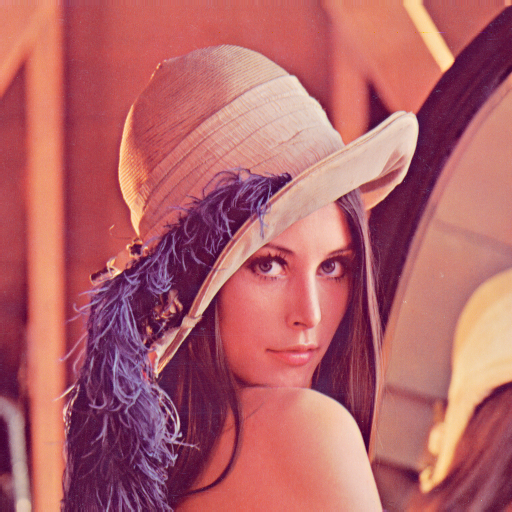

In [47]:
img = testimage("lena_color_512")

In [48]:
imgarr = tfms(img)

typeof(imgarr), size(imgarr)

(Array{Float64,3}, (32, 32, 3))

# Looking at labels

In [49]:
gettargets(ds::ImageFolderDataset, i) = ds.labels[i]

gettargets (generic function with 12 methods)

After defining `gettargets()`, we can use MLDataUtils magic to do cool stuff

Like iterating over all targets

In [50]:
[lbl^2 for lbl in eachtarget(ds)]

9-element Array{String,1}:
 "CatCat"
 "CatCat"
 "CatCat"
 "CatCat"
 "CatCat"
 "DogDog"
 "DogDog"
 "DogDog"
 "DogDog"

Plotting frequencies

In [51]:
barplot(labelfreq(targets(ds)))

       ┌                                        ┐ 
   Cat ┤■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 5   
   Dog ┤■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■ 4          
       └                                        ┘ 

And onehot encoding

In [52]:
convertlabel(LabelEnc.OneOfK, targets(ds))

2×9 Array{Int64,2}:
 1  1  1  1  1  0  0  0  0
 0  0  0  0  0  1  1  1  1

# Putting it all together

In [53]:
ds = ImageFolderDataset("/Users/user/Data/", transform=tfms)

ImageFolderDataset(9 observations)

In [54]:
imgs, lbls = getobs((ds, targets(ds)), 1:3);

In [55]:
size(imgs), lbls

((32, 32, 3, 3), ["Cat", "Cat", "Cat"])

In [56]:
X, y = shuffleobs((ds, convertlabel(LabelEnc.OneOfK, targets(ds))))

(DataSubset(::ImageFolderDataset, ::Array{Int64,1}, ObsDim.Undefined())
 9 observations, [0 1 … 1 0; 1 0 … 0 1])

In [57]:
y

2×9 view(::Array{Int64,2}, :, [7, 5, 1, 2, 8, 9, 4, 3, 6]) with eltype Int64:
 0  1  1  1  0  0  1  1  0
 1  0  0  0  1  1  0  0  1

In [58]:
dl = RandomBatches((ds, convertlabel(LabelEnc.OneOfK, targets(ds))), 4)

RandomBatches(::Tuple{ImageFolderDataset,Array{Int64,2}}, 4, (ObsDim.Undefined(), ObsDim.Last()))
 Iterator providing Inf batches of size 4

In [59]:
x, y = iterate(dl)

((DataSubset(::ImageFolderDataset, ::Array{Int64,1}, ObsDim.Undefined())
 4 observations, [0 0 0 0; 1 1 1 1]), 1)